# Univariate to Univariate Prediction
**This notebook compares the current LSTM model trained on emotion data against two naive models**:

1. Mean Model: Takes the mean of all timesteps in the lookback period.
2. Learnable Weighted Mean Model: Computes a weighted mean of all previous timesteps, where the weights are learned.



### For prediction, I will explore two approaches:
1. Recursive Single Prediction: Predicts future time steps one at a time using previous prediction as input for the next prediction.
2. All-Timestep Prediction: Predicts all future timesteps in one shot.

Imports

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/Users/arnav/Google Drive/Cornell/Coding Projects/emili_TimeSeriesPredictor') #going up several files until emili_TimeSeriesPredictor
from time_series_predictor.Data.emotionFeatureExtractor import emotionFeatureExtractor
#Modeling imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Input, Lambda
from tensorflow.keras.regularizers import l1, l2
import tensorflow.keras.backend as K

### **Generating Synthetic Data**

**Parameters**

In [149]:
delta_t = 0.1
lookback = 600
forecast = 1
stride = lookback + forecast #so no overlap

nSamples = 30
noise_lvl = 0.0

**Univariate synthetic data:**

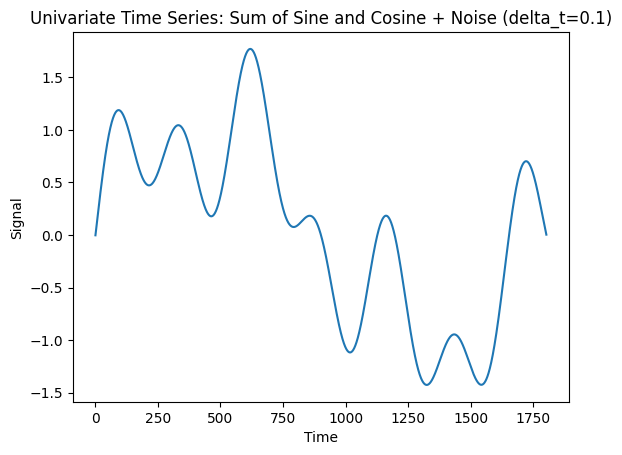

In [150]:

def gen_univariate_synthetic_data(timesteps, delta_t, noise_level = 0.1):
    t = np.linspace(0, (timesteps-1)*delta_t, timesteps)

    signal = np.sin(2*np.pi/(0.1*timesteps)*t) + np.sin(10*np.pi/(0.1*timesteps)*t-5/(0.1*timesteps))*np.cos(10/(0.1*timesteps)*t)

    noise = np.random.normal(0, noise_level, timesteps)

    return t, signal + noise

t,univariate_data = gen_univariate_synthetic_data(timesteps = (lookback+forecast)*nSamples, delta_t=delta_t, noise_level=noise_lvl)

plt.plot(t, univariate_data)
plt.title(f"Univariate Time Series: Sum of Sine and Cosine + Noise (delta_t={delta_t})")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.show()

**Creating train-test-split**

In [151]:

def train_test_split(data, lookback_period, forecast_period, stride, test_split = 0.2):
    # Ensure data is a numpy array
    data = np.array(data)

    # Initialize lists to hold the segmented data
    x, y = [], []

    # Loop over the dataset and create x and y using the sliding window approach
    for i in range(0, len(data) - lookback_period - forecast_period + 1, stride):
        x.append(data[i:i + lookback_period])
        y.append(data[i + lookback_period:i + lookback_period + forecast_period])

    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)

    #creating new axis so data is (#samples, timesteps, features)
    if len(np.shape(x)) == 2:
        x = x[:,:,np.newaxis]
    if len(np.shape(y)) == 2:
        y = y[:,:,np.newaxis]

    # Determine the split point for the training and testing sets
    split_idx = int(np.shape(x)[0] * (1 - test_split))

    # Split the data into training and testing sets
    x_train, x_test = x[:split_idx], x[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return x_train, y_train, x_test, y_test


xTr,yTr,xTe,yTe = train_test_split(data = univariate_data, lookback_period = lookback, forecast_period = forecast, stride = stride)
print(xTr.shape) # (samples, length of sample = lookback, features for timestep)
print(xTe.shape)
print(yTr.shape) # (samples, length of forecast = forecast, 1) Predicting 1 feature
print(yTe.shape)

(24, 600, 1)
(6, 600, 1)
(24, 1, 1)
(6, 1, 1)


**Plotting the univariate data train and test samples to verify**

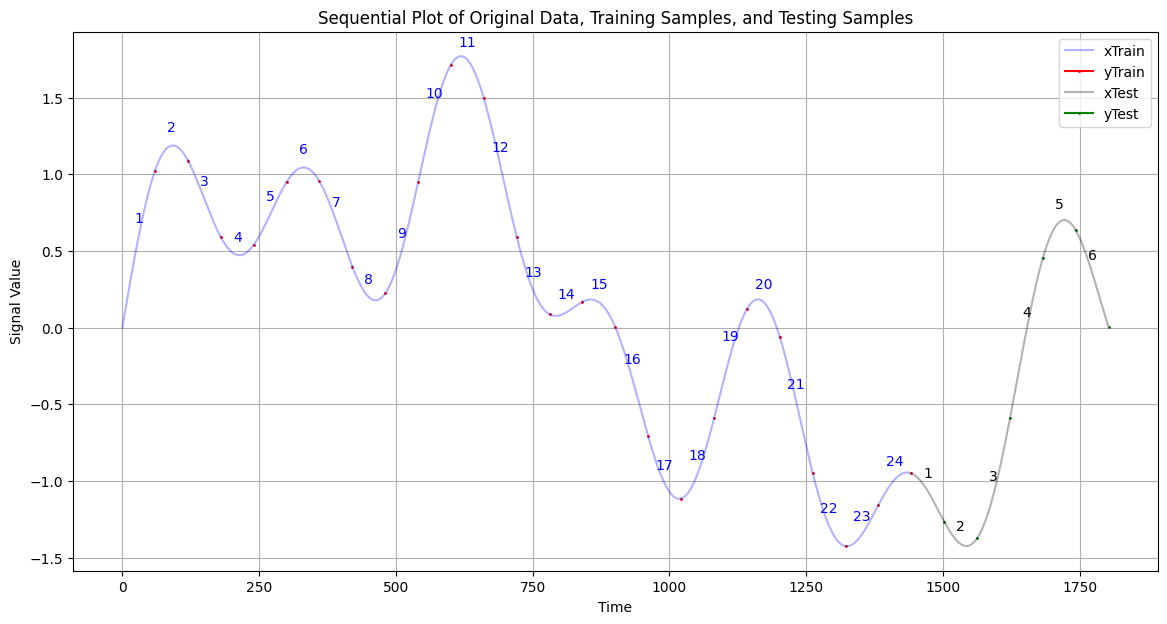

In [152]:

def plot_sequential_samples(univariate_data, x_train, y_train, x_test, y_test, delta_t):
    """
    Plots the original univariate data along with sequentially plotted x_train, y_train, x_test, and y_test.

    Parameters:
    - univariate_data: Original univariate time series data (1D array).
    - x_train: Training input data (2D array).
    - y_train: Training output data (2D array).
    - x_test: Testing input data (2D array).
    - y_test: Testing output data (2D array).
    - delta_t: The time interval between consecutive time steps.
    """
    plt.figure(figsize=(14, 7))

    # Plot original univariate data
    t_original = np.arange(len(univariate_data)) * delta_t
    # plt.plot(t_original, univariate_data, color='black', label='Original Data', linewidth=1.5)

    
    # Plot training data (x_train and y_train) sequentially
    lookback_period = x_train.shape[1]
    forecast_period = y_train.shape[1]
    start = 0
    for i in range(x_train.shape[0]):
        t_x_train = t_original[start:start + lookback_period]
        start += lookback_period
        t_y_train = t_original[start:start + forecast_period]
        start += forecast_period
        plt.plot(t_x_train, x_train[i], color='blue', alpha=0.3, linestyle='-', label='xTrain' if i == 0 else '')
        plt.annotate(f'{i+1}', (t_x_train[lookback_period//2], x_train[i, lookback_period//2]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
        plt.plot(t_y_train, y_train[i], color='red', marker = 'o', markersize = 1,label='yTrain' if i == 0 else '')
        # plt.annotate(f'{i+1}', (t_y_train[0], y_train[i, 0]), textcoords="offset points", xytext=(0,10), ha='center', color='red')


    # Plot testing data (x_test and y_test) sequentially
    for i in range(x_test.shape[0]):
        t_x_test = t_original[start:start + lookback_period]
        start += lookback_period
        t_y_test = t_original[start:start + forecast_period]
        start += forecast_period
        plt.plot(t_x_test, x_test[i], color='black', alpha=0.3, linestyle='-', label='xTest' if i == 0 else '')
        plt.annotate(f'{i+1}', (t_x_test[lookback_period//2], x_test[i, lookback_period//2]), textcoords="offset points", xytext=(0,10), ha='center', color='black')
        plt.plot(t_y_test, y_test[i], color='green', marker = 'o', markersize = 1, label='yTest' if i == 0 else '')

    plt.title("Sequential Plot of Original Data, Training Samples, and Testing Samples")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Example usage (assuming xTr, yTr, xTe, and yTe are defined)
plot_sequential_samples(univariate_data, xTr, yTr, xTe, yTe, delta_t)

# Models

**Training and Prediction Functions**

In [153]:

def train(model, xTrain, yTrain, xVal=None, yVal=None, epochs=10, batch_size=32):
    """
    Trains the model.

    Parameters:
    - model (tf.keras.Model): The Keras model to be trained.
    - xTrain (numpy.ndarray): Training data of shape (batch_size, timesteps, features).
    - yTrain (numpy.ndarray): True values corresponding to the training data, typically of shape (batch_size, 1 future timestep, features).
    - xVal (numpy.ndarray, optional): Validation data of shape (batch_size, timesteps, features).
    - yVal (numpy.ndarray, optional): Validation labels corresponding to the validation data.
    - epochs (int, optional): The number of epochs to train the model (default is 10).
    - batch_size (int, optional): The batch size used during training (default is 32).

    Returns:
    - history (History object): Keras history object containing training and validation loss/metrics.
    """

    # Prepare the training data and labels
    if xVal is not None and yVal is not None:
        # Train with validation data
        history = model.fit(
            xTrain, yTrain,
            validation_data=(xVal, yVal),
            epochs=epochs,
            batch_size=batch_size
        )
    else:
        # Train without validation data
        history = model.fit(
            xTrain, yTrain,
            epochs=epochs,
            batch_size=batch_size
        )

    return history


def predict(model, input_data):
    """
    Makes predictions using the provided model and input data.
    
    Parameters:
    - model (tf.keras.Model): The Keras model used for predictions.
    - input_data (numpy.ndarray): Input data of shape (batch_size, timesteps, features).
    
    Returns:
    - output (numpy.ndarray): Model predictions.
    """
    
    # Make a prediction
    output = model.predict(input_data)
    
    return output

def recursive_predict(model, input_data, num_steps):
    predictions = []
    current_input = input_data

    for _ in range(num_steps):
        # Predict the next timestep
        next_pred = predict(model, current_input)
        predictions.append(next_pred)
        
        # Use the predicted value as part of the new input for the next timestep
        current_input = np.roll(current_input, shift=-1, axis=1)  # Shift the input sequence up 1
        current_input[:, -1, :] = next_pred  # Replace last time step with the new prediction
    
    return np.array(predictions)

**Average Model**

In [154]:
'''
This model requires no training
Predicts the next point as an average of the training points
Works with multivarate data
Creates an mean vector for each sample
'''

def average_model_predict(series):
    return np.average(series, axis = 1)

multivariate_test_data = xTr #np.repeat(xTr,repeats=3,axis = -1)
multivariate_test_data.shape

(24, 600, 1)

**Weighted Average Model:**
*Weights are learned during back propagation*

In [156]:
def time_weighted_sum_model(input_shape):
    """
    Create a model that applies a learnable weight to each timestep's 7-dimensional vector,
    then sums these weighted vectors element-wise across all timesteps.

    Parameters:
    input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    model (tf.keras.Model): Compiled Keras model.
    """

    # Input layer for time series data (batch_size, 600, 7)
    input_layer = Input(shape=input_shape)  # Shape: (batch_size, 600, 7)

    # Dense layer to generate learnable weights for each timestep
    time_step_weights = Dense(1, activation=None)(input_layer)  # Shape: (batch_size, 600, 1)

    # Multiply the learnable scalar weights with the corresponding 7-dimensional vectors
    weighted_time_steps = Multiply()([input_layer, time_step_weights])  # Shape: (batch_size, 600, 7)

    # Sum the weighted vectors element-wise across the time dimension (axis=1)
    output = Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted_time_steps)  # Shape: (batch_size, 7)

    # Build and compile the model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

def build_weighted_average_model(timesteps, features):
    """
    Builds a model that applies a weighted average across timesteps, keeping the feature dimension intact.

    Parameters:
    - timesteps (int): The number of timesteps in the input sequence.
    - features (int): The number of features at each timestep.

    Returns:
    - model (tf.keras.Model): The Keras model.
    """
    
    # Input layer: (timesteps, features)
    inputs = Input(shape=(timesteps, features))
    
    # Learnable weights to apply weighted average across timesteps
    # We'll create a weight vector of shape (timesteps, 1)
    weights = Dense(1, activation='softmax', use_bias=False)(inputs)
    
    # Apply the weighted sum across timesteps
    # Multiply the weights with the inputs, then sum across timesteps (axis=1)
    weighted_sum = Lambda(lambda x: K.sum(x[0] * x[1], axis=1))([weights, inputs])
    
    # Create the model
    model = Model(inputs=inputs, outputs=weighted_sum)
    
    # Compile the model (optional for running this example)
    model.compile(optimizer='adam', loss='kl_divergence')
    
    # View the model summary
    model.summary()
    
    return model

# Example usage
# input_data = multivariate_test_data  # Example input data
# weighted_average_model = build_weighted_average_model(timesteps=input_data.shape[1], features=input_data.shape[2])
# output = predict(weighted_average_model, input_data)
# print(f"Output shape: {output.shape}")
# print(f"Predicted output: {output}")

**LSTM Model**
*Single Value Prediction*

In [ ]:
def build_LSTM_univariate_single_pred(timesteps, features, lstm_units=64, learning_rate=0.001):
    """
    Builds a model that applies an LSTM to predict the next value

    Parameters:
    - timesteps (int): The number of timesteps in the input sequence.
    - features (int): The number of features at each timestep.
    - lstm_units: Number of units in each LSTM layer. If None, uses self.LSTMUnits.
    - learning_rate: Learning rate for the Adam optimizer.

    Returns:
    - model (tf.keras.Model): The Keras model.
    """

    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(timesteps, features), return_sequences=False))

    model.add(Dense(features))
    # Compile the model (optional for running this example)
    # Compile the model
    model.compile(loss='kl_divergence',
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=['accuracy'])
    
    # View the model summary
    model.summary()
    
    return model
# input_data = multivariate_test_data  # Example input data
# lstm = build_LSTM_univariate_single_pred(timesteps=input_data.shape[1], features=input_data.shape[2])
# output = predict(lstm, input_data)
# print(f"Output shape: {output.shape}")
# print(f"Predicted output: {output}")